In [1]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet34
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode



In [2]:
# Step 1: Preprocess the Data
data_file = 'source_input/Model_A_output_mini.csv'  
data_list = []
class_names=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'] 
# Read the data file and extract image paths and class labels
with open(data_file, 'r') as f:
    for line in f:
        img_path, label = line.strip().split(',')
        data_list.append((img_path, int(label)))


# Step 2: Create a Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_path, label = self.data_list[idx]
        # print(type(label))
        image = Image.open('source_input/'+img_path.replace('\\','/') ).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label
    
    def __getclasses__(self, data_list):
        classes = {item[1] for item in data_list}
        return list(classes)

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
custom_dataset = CustomDataset(data_list, transform=data_transforms['train'])

data_dir = 'data_mini'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in [ 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['val']}
dataloaders['train']=DataLoader(custom_dataset, batch_size=4, shuffle=True,num_workers=0)
print(dataloaders)
dataset_sizes = {x: len(image_datasets[x]) for x in ['val']}

dataset_sizes['train']=custom_dataset.__len__()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'val': <torch.utils.data.dataloader.DataLoader object at 0x000002CDD3FCB6D0>, 'train': <torch.utils.data.dataloader.DataLoader object at 0x000002CDD3979250>}


In [4]:
dataset_sizes

{'val': 1708, 'train': 10000}

In [5]:
dataloaders

{'val': <torch.utils.data.dataloader.DataLoader at 0x2cdd3fcb6d0>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x2cdd3979250>}

In [6]:
classes = custom_dataset.__getclasses__(data_list)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

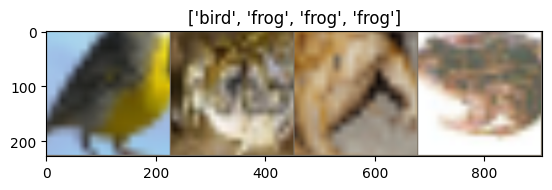

In [8]:
class_names=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'] 

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes_ = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes_])

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=2):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [10]:
def visualize_model(model, num_images=2):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    # classes=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'] 


    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                print(class_names)
                print(outputs)
                ax.set_title(f'predicted: {class_names[classes[preds[j]]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
model_ft = models.resnet34(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



In [13]:
model_ft = train_model(model_ft,
                        criterion, 
                        optimizer_ft,
                          exp_lr_scheduler,
                       num_epochs=4)

Epoch 0/3
----------
train Loss: 1.4068 Acc: 0.5240
val Loss: 2.8363 Acc: 0.1159

Epoch 1/3
----------
train Loss: 1.2016 Acc: 0.5833
val Loss: 2.5744 Acc: 0.1727

Epoch 2/3
----------
train Loss: 1.1103 Acc: 0.6155
val Loss: 2.2534 Acc: 0.3296

Epoch 3/3
----------
train Loss: 1.0406 Acc: 0.6380
val Loss: 2.3540 Acc: 0.3841

Training complete in 226m 8s
Best val Acc: 0.384075


Epoch 0/3
----------
train Loss: 1.4068 Acc: 0.5240
val Loss: 2.8363 Acc: 0.1159

Epoch 1/3
----------
train Loss: 1.2016 Acc: 0.5833
val Loss: 2.5744 Acc: 0.1727

Epoch 2/3
----------
train Loss: 1.1103 Acc: 0.6155
val Loss: 2.2534 Acc: 0.3296

Epoch 3/3
----------
train Loss: 1.0406 Acc: 0.6380
val Loss: 2.3540 Acc: 0.3841

Training complete in 226m 8s
Best val Acc: 0.384075

In [14]:
torch.save(model_ft.state_dict(), 'model_state/modelA.pth')

In [17]:
model_path = 'model_state/modelA.pth'

# Load the model
model_loaded = torch.load(model_path)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
tensor([[ 0.4093, -2.2105,  3.7865,  3.0090,  0.4200, -0.9984,  1.4860, -2.3859,
         -2.4395, -2.3669],
        [ 1.5672, -1.9595,  1.4243,  2.3133,  2.3359, -1.7655,  0.8994, -1.7048,
         -1.7425, -1.5718],
        [ 5.2478, -1.0257,  5.8856,  0.8815, -2.3881, -2.3318, -0.1838, -2.6364,
         -1.6407, -3.0066],
        [ 3.1814, -0.7734,  0.3000,  2.4300, -0.4841, -1.6671,  0.9568, -1.7690,
         -0.4701, -2.0520]])


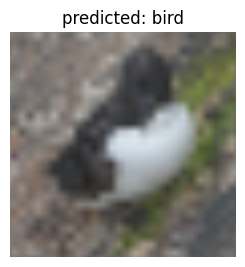

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
tensor([[ 0.4093, -2.2105,  3.7865,  3.0090,  0.4200, -0.9984,  1.4860, -2.3859,
         -2.4395, -2.3669],
        [ 1.5672, -1.9595,  1.4243,  2.3133,  2.3359, -1.7655,  0.8994, -1.7048,
         -1.7425, -1.5718],
        [ 5.2478, -1.0257,  5.8856,  0.8815, -2.3881, -2.3318, -0.1838, -2.6364,
         -1.6407, -3.0066],
        [ 3.1814, -0.7734,  0.3000,  2.4300, -0.4841, -1.6671,  0.9568, -1.7690,
         -0.4701, -2.0520]])


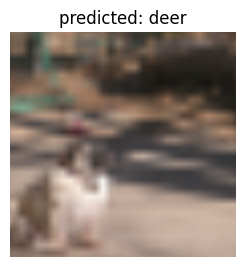

In [18]:
visualize_model(model_ft)